# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [1]:
from sklearn.metrics import roc_auc_score
import time, datetime
import requests
import json
import pandas as pd
import time
from datetime import datetime
import nltk
nltk.download('wordnet')

import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import numpy as np

from sklearn import svm

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jameshampton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load CSV

We load our cumulative csv and drop duplicated posts, since the same post can show up on scrapes from different days.

In [163]:
cumulative_df = pd.read_csv("reddit-cumulative.csv")

cumulative_df = cumulative_df.sort_values(by='num_comments', ascending=False)

cumulative_df = cumulative_df.drop_duplicates(subset='id')

## Predicting comments using Random Forests + Another Classifier

#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

# General Analysis

We'll begin our analysis of the reddit "hot" page posts by loading our cumulative csv.  We'll clean it up a bit, maybe put in some interesting features, and then we'll do some EDA.  After looking at the data, we'll get into model building and hyperparameter tuning.  Once we wrap up the general analysis, we'll dive into some subreddit-specific analysis.

In [164]:
# First, define our median

median = cumulative_df['num_comments'].median()
y = (cumulative_df['num_comments']>median).astype(int)


In [165]:
cumulative_df['age'] = cumulative_df['time_fetched'].astype('datetime64[s]') - cumulative_df['created_utc'].astype('datetime64[s]')

cumulative_df['age_s'] = cumulative_df['age'].astype('timedelta64[s]')
cumulative_df['age_mins'] = cumulative_df['age'].astype('timedelta64[m]')
cumulative_df['age_hrs'] = cumulative_df['age'].astype('timedelta64[h]')

X = pd.get_dummies(cumulative_df[['age_hrs','age_mins','age_s','subreddit','title']],columns = ['subreddit'])

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [160]:
cumulative_df['age_mins'].dtype

dtype('float64')

In [161]:
def leveller(train, test):
    tr_feats = train.columns
    te_feats = test.columns
    for feat in set(tr_feats)-set(te_feats):
        test[feat]=0
    return train, test[tr_feats]

In [166]:
# Vectorize titles, then add them back into the feature dataframe.  Fit an untuned logistic model to get a baseline.
cvec = CountVectorizer()

X_train_counts = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(), columns = ["t_"+w for w in cvec.get_feature_names()], index = X_train.index)
X_test_counts = pd.DataFrame(cvec.transform(X_test['title']).todense(), columns = ["t_" + w for w in cvec.get_feature_names()], index=X_test.index)

print(X_train_counts.shape, X_test_counts.shape)

X_train_full = pd.concat([X_train.drop(labels = ['title'], axis=1),X_train_counts],axis=1)
X_test_full = pd.concat([X_test.drop(labels = ['title'],axis=1),X_test_counts],axis=1)

print(X_train_full.shape, X_test_full.shape)

X_train_full, X_test_full = leveller(X_train_full, X_test_full)

model = LogisticRegression().fit(X_train_full,y_train)
model.score(X_test_full,y_test)

(3781, 8876) (1261, 8876)
(3781, 10217) (1261, 10217)


0.5107057890563045

Yikes, that's terrible.  Let's gridsearch to tune hyperparameters and prune our age features.

### Age features

We'll just do some trial-and-error searching here to see which age feature (if any) is worth keeping around

In [11]:
# Try all age features
gs_log = GridSearchCV(LogisticRegression(),{
    'C':np.logspace(-6, 2, 10)
})

gs_log.fit(X_train_full, y_train)
gs_log.best_params_, gs_log.best_score_, gs_log.score(X_test_full, y_test)

({'C': 1.6681005372000557}, 0.6942607775720708, 0.7081681205392546)

In [77]:
# Keep age in seconds
model = gs_log.fit(X_train_full.drop(['age_hrs', 'age_mins'],axis=1),y_train)
gs_log.score(X_test_full.drop(['age_hrs', 'age_mins'],axis=1),y_test)

0.4964314036478985

In [78]:
# Keep age in mins
gs_log.fit(X_train_full.drop(['age_s', 'age_hrs'],axis=1),y_train)
gs_log.score(X_test_full.drop(['age_s', 'age_hrs'],axis=1),y_test)

0.7137192704203014

In [80]:
# Keep age in hrs only
gs_log.fit(X_train_full.drop(['age_s', 'age_mins'],axis=1),y_train)
gs_log.score(X_test_full.drop(['age_s', 'age_mins'],axis=1),y_test)

0.711340206185567

In [79]:
# Drop age altogether
gs_log.fit(X_train_full.drop(['age_s', 'age_mins','age_hrs'],axis=1),y_train)
gs_log.score(X_test_full.drop(['age_s', 'age_mins','age_hrs'],axis=1),y_test)

0.6463124504361618

It looks like there's little difference in keeping age in mins vs hrs.  We'll keep in hours.

We'll want a fully-featured train and test set.  This gets a bit complicated, since we have some features that need to be dummied, some features that need to be vectorized, and some features that need to be left alone.  This next cell is a bit complicated, but note in particular the decision to prefix the features in the Vectorizer call.  This is needed in case one of the words in the title is identical to one of our feature names.  

In [167]:
X = pd.get_dummies(cumulative_df[['age_hrs','subreddit','title']],columns = ['subreddit'])

X_train, X_test, y_train, y_test = train_test_split(X,y)

cvec = CountVectorizer()

X_train_counts = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(), columns = ["t_"+w for w in cvec.get_feature_names()], index = X_train.index)
X_test_counts = pd.DataFrame(cvec.transform(X_test['title']).todense(), columns = ["t_" + w for w in cvec.get_feature_names()], index=X_test.index)

print(X_train_counts.shape, X_test_counts.shape)

X_train_full = pd.concat([X_train.drop(labels = ['title'], axis=1),X_train_counts],axis=1)
X_test_full = pd.concat([X_test.drop(labels = ['title'],axis=1),X_test_counts],axis=1)

print(X_train_full.shape, X_test_full.shape)

X_train_full, X_test_full = leveller(X_train_full, X_test_full)

(3781, 8838) (1261, 8838)
(3781, 10177) (1261, 10177)


# Visualizing Subreddit Information
Common sense suggests that more popular subreddits will appear more frequently in collections of top posts--this will be borne out in our logistic modelling later.

Let's take a look at which subreddits appear in the top posts.  To make the visualization easier to interpret, we'll only consider posts in the top 10% by number of comments.

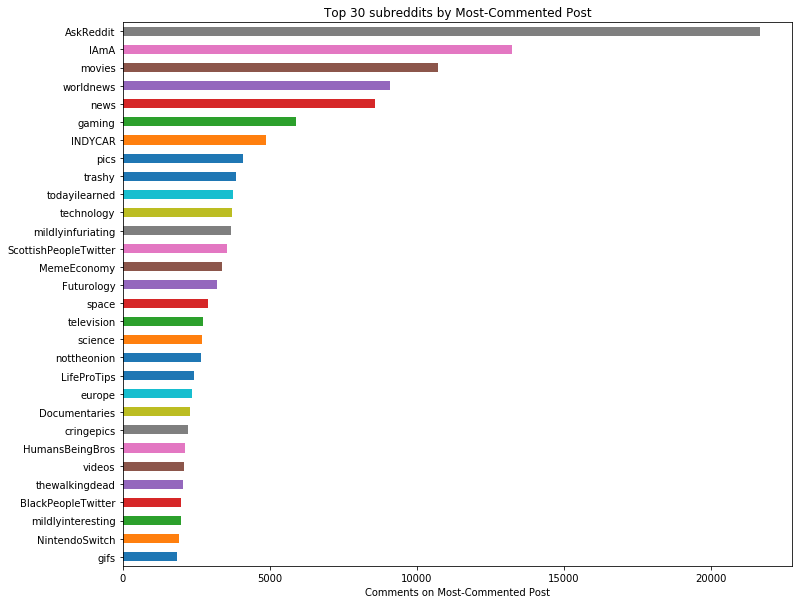

In [169]:
plt.figure(figsize = (12,10))
cumulative_df.groupby('subreddit')['num_comments'].max().sort_values().tail(30).plot(kind='barh')
plt.title('Top 30 subreddits by Most-Commented Post')
plt.xlabel('Comments on Most-Commented Post')
plt.ylabel("")
plt.show()

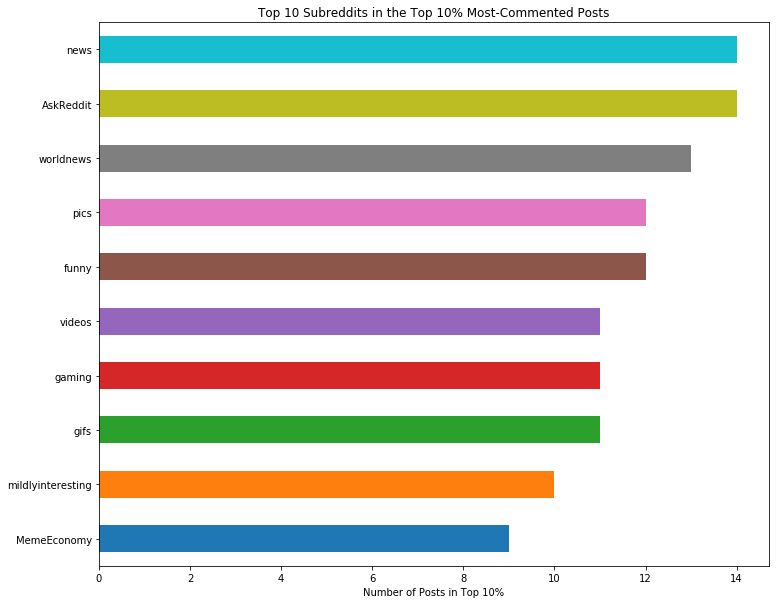

In [171]:
# Let's see what subreddits appear consistently.
plt.figure(figsize = (12,10))
cumulative_df.sort_values(by='num_comments', ascending=False).head(int(np.ceil(cumulative_df.shape[0]*0.1))).groupby('subreddit').size().sort_values().tail(10).plot(kind='barh')
plt.title("Top 10 Subreddits in the Top 10% Most-Commented Posts")
plt.xlabel("Number of Posts in Top 10%")
plt.ylabel("")
plt.show()

This is a *very* interesting graph, because it identifies subreddits that consistently appear among the hottest posts with the most comments.  After we finish analyzing the general reddit data, we'll use the subreddits appearing in this graph to guide our deeper dive into per-subreddit analysis.

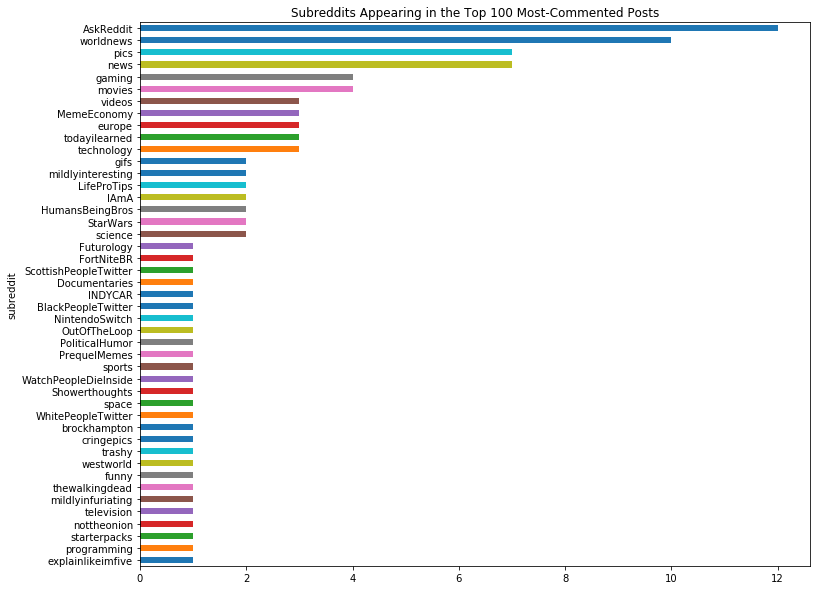

In [340]:
# This one's just for fun, to see how long the tail is for the previous graph.
plt.figure(figsize = (12,10))
cumulative_df.sort_values(by='num_comments', ascending=False).head(100).groupby('subreddit').size().sort_values().plot(kind='barh')
plt.title("Subreddits Appearing in the Top 100 Most-Commented Posts")
plt.show()

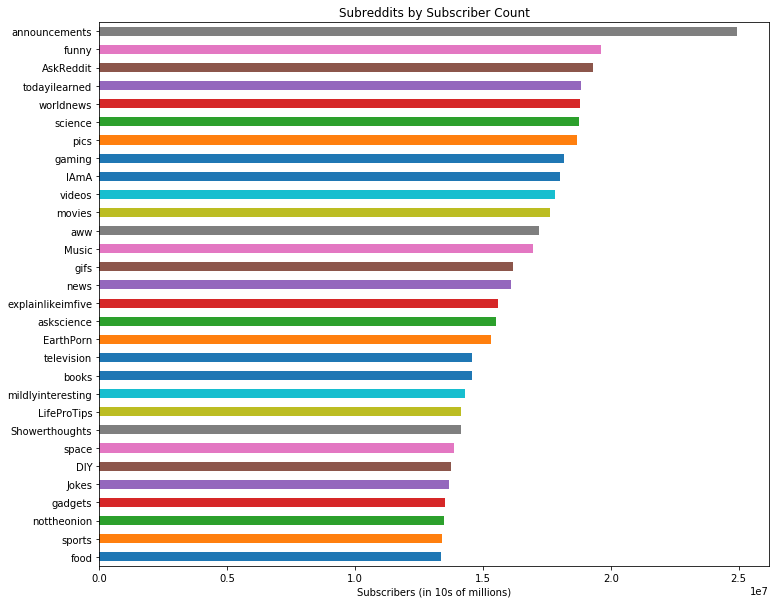

In [172]:
# What are the biggest subreddits by subscribers?
plt.figure(figsize = (12,10))
cumulative_df.groupby('subreddit')['subreddit_subscribers'].max().sort_values().tail(30).plot(kind='barh')
plt.title('Subreddits by Subscriber Count')
plt.xlabel('Subscribers (in 10s of millions)')
plt.ylabel("")
plt.show()

# Naive Bayes

Here we're just getting practice implementing Naive Bayes classifiers.  We'll fit both Bernoulli and Multinomial classifiers.

In [19]:
gs_bnb = GridSearchCV(BernoulliNB(),{
    'alpha':np.linspace(0.01,1,20)
})
gs_bnb.fit(X_train_full, y_train)
bnb_model = gs_bnb.best_estimator_
gs_bnb.best_params_

{'alpha': 0.2705263157894737}

In [20]:
gs_bnb.score(X_test_full, y_test)

0.6455194290245837

In [21]:
gs_mnb = GridSearchCV(MultinomialNB(), {
    'alpha':np.linspace(0.01,10,10)
})

gs_mnb.fit(X_train_full, y_train)

mnb_model= gs_mnb.best_estimator_

mnb_model.score(X_test_full,y_test)

0.6304520222045995

# Decision Tree Implementation

Here we'll implement both a single tree and a tuned single tree.  Later on we'll try out a random forest classifier as well.

In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train_full,y_train)
dt.score(X_train_full, y_train), dt.score(X_test_full, y_test)

(0.9989420788151283, 0.6518636003172086)

In [25]:
gs_dt = GridSearchCV(DecisionTreeClassifier(),{
    'max_depth' : [None, 3,4,5],
    'max_features':np.linspace(.1,1.0,10)
})
gs_dt.fit(X_train_full, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [None, 3, 4, 5], 'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
gs_dt.best_score_, gs_dt.score(X_test_full, y_test)

(0.6537952922507273, 0.6637589214908802)

In [27]:
dt_best = gs_dt.best_estimator_

# ROC Plotting:

To get a better idea of how our classifiers compare to one another, we'll plot some RoC curves and see if any model appears to be preferable.  We'll build our RoC plotter from scratch.

In [13]:
def get_preds(model, X_test, thresh):
    preds = pd.Series([p[1] for p in model.predict_proba(X_test)])
    return preds.map(lambda x: 1 if x >= thresh else 0)

In [14]:
def get_sens_spec(y_true, predictions):
    cm = confusion_matrix(y_true, predictions)
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]       
    FN = cm[1][0]
    # return Sensitivity, Specificity
    return (TP/(TP+FN)), (TN/(FP+TN))

In [15]:
def get_roc_values(model, X_test, y_test):
    # Construct parameter space
    probs = np.linspace(0,1,101)
    sens = []
    spec = []
    for prob in probs:
        preds = get_preds(model, X_test, prob)
        t_sens, t_spec = get_sens_spec(y_test, preds)
        sens.append(t_sens)
        spec.append(t_spec)
    return sens, spec

In [16]:
def add_roc(ax, model, label,X_test, y_test):
    sens, spec = get_roc_values(model, X_test, y_test)
    x_vals = [1-s for s in spec]
    ax.plot(x_vals, sens, label = label)

In [17]:
def roc_plotter(model_list,label_list, X_test, y_test, title):
    plt.close()
    plt.figure(figsize=(15,12))
    ax = plt.gca()
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    for idx, model in enumerate(model_list):
        add_roc(ax, model, label_list[idx], X_test, y_test)
    ax.plot([0,1], [0,1], linestyle = '--', color = "red",)
    plt.legend()
    plt.title(title)
    plt.show()

With all that done, let's take a look at our RoC curves:

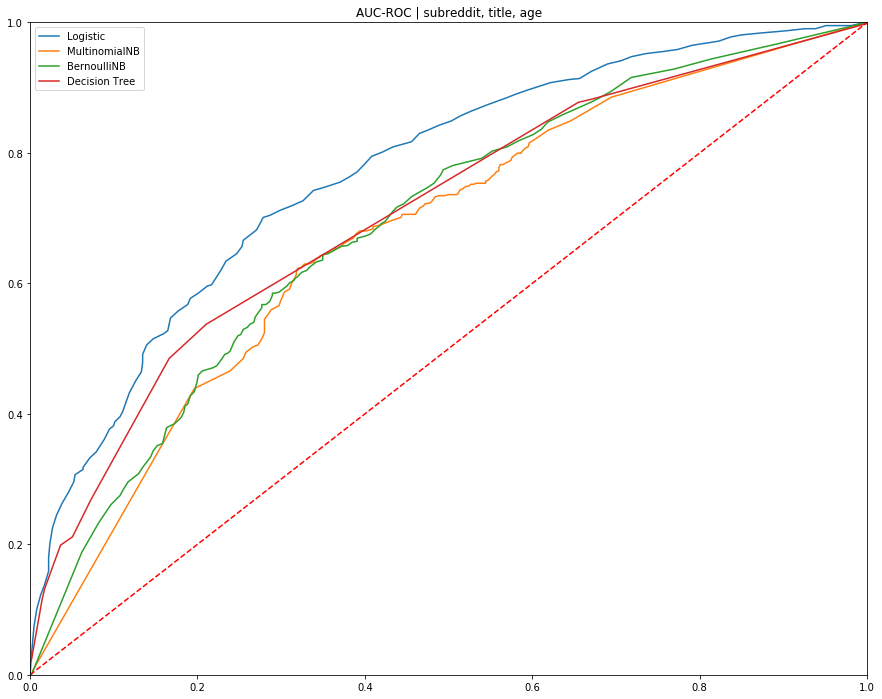

In [33]:
roc_plotter([best_model,mnb_model,bnb_model, gs_dt.best_estimator_],['Logistic', 'MultinomialNB', 'BernoulliNB', 'Decision Tree'], X_test_full, y_test,'AUC-ROC | subreddit, title, age')

Logistic looks to have a pretty clear advantage over the others.  

# Feature Selection

In the next section, we'll redo some of the previous analysis but without doing any NLP on the post titles.  Then we'll compare our results to our earlier work and settle on a model.

# Age and Subreddit only

In [212]:
# Slice out the vectorized title features.  Our "t_" prefix comes in handy here.

features = [col for col in X_train_full.columns if not col.startswith("t_")]
X_train_as, X_test_as = X_train_full[features].values, X_test_full[features].values

### Logistic Regression implementation

In [213]:
as_log = GridSearchCV(LogisticRegression(), {
    'C' : np.logspace(-6, 2, 20)
})

as_log.fit(X_train_as, y_train)
as_log.best_params_, as_log.score(X_test_as, y_test)

({'C': 5.455594781168514}, 0.7541633624107851)

In [348]:
# This bit of code is helpful for looking at the coefficients of the Logistic function as well as the features they correspond to.
coefs = pd.DataFrame(as_log.best_estimator_.coef_, columns = features, index=['coefs']).T.sort_values(by='coefs', ascending=False)

### Decision Tree Implementation

In [88]:
as_dt = GridSearchCV(DecisionTreeClassifier(),{
    'max_depth' : [None, 3,4,5],
    'max_features':np.linspace(.1,1,10)
})

as_dt.fit(X_train_as, y_train)
as_dt.score(X_test_as, y_test)

0.6907216494845361

### Naive Bayes Implementation

In [89]:
gs_bnb = GridSearchCV(BernoulliNB(),{
    'alpha':np.logspace(-5,2,20)
})
gs_bnb.fit(X_train_as, y_train)
bnb_model = gs_bnb.best_estimator_
gs_bnb.best_params_, gs_bnb.score(X_test_as, y_test)

({'alpha': 1.438449888287663}, 0.7010309278350515)

In [91]:
gs_mnb = GridSearchCV(MultinomialNB(), {
    'alpha':np.linspace(0,10,10)
})

gs_mnb.fit(X_train_as, y_train)

mnb_model= gs_mnb.best_estimator_

mnb_model.score(X_test_as,y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.7057890563045203

## Model comparison

As before, we'll plot the roc curve for each model on the same axes and look for a clear winner.

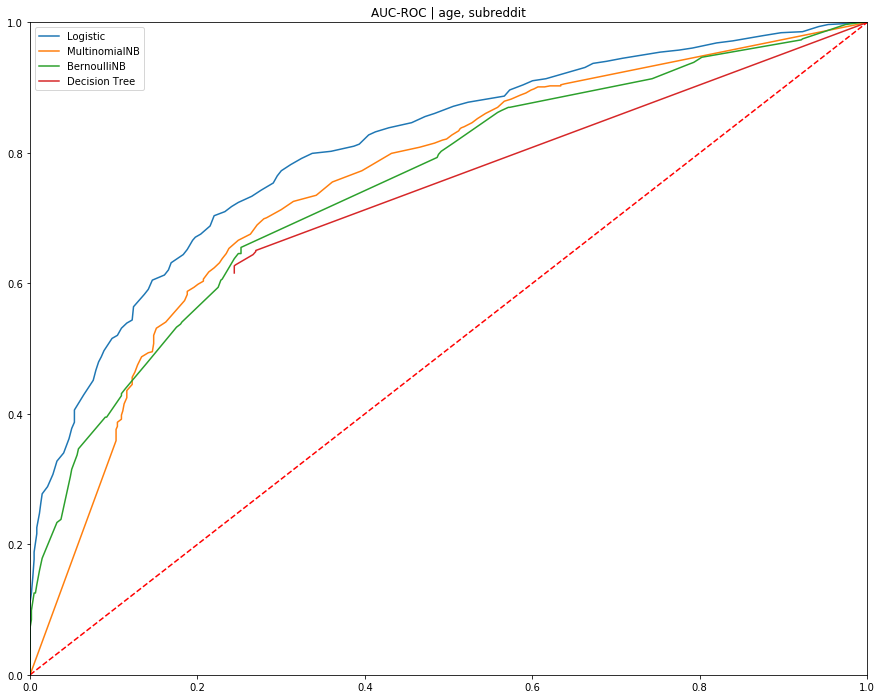

In [97]:
roc_plotter([as_log.best_estimator_,mnb_model,bnb_model, as_dt.best_estimator_],['Logistic', 'MultinomialNB', 'BernoulliNB', 'Decision Tree'], X_test_as, y_test, 'AUC-ROC | age, subreddit')

## Summary

It looks like Logistic regression is superior to Bayesian and Decision tree models.  We'll compare against various ensemble methods later, but for singular models, Logistic looks to be the best performer.

# Support Vectors

This section was mostly just for experience implementing support vectors.  They didn't do to well, and they took forever to train.  We might revisit this in the future.

In [48]:
%%time
sv = svm.SVC(kernel = 'rbf', probability = True, verbose = 1)
sv.fit(X_train_full, y_train)
sv.score(X_test_full, y_test)

[LibSVM]CPU times: user 13min 24s, sys: 2.6 s, total: 13min 27s
Wall time: 13min 29s


In [49]:
%%time
print(sv.score(X_test_full, y_test))

0.6352101506740682
CPU times: user 46.1 s, sys: 67.8 ms, total: 46.2 s
Wall time: 46.2 s


In [16]:
%%time

sv_lin = svm.SVC(kernel='linear')
sv_lin.fit(X_train_full, y_train)
sv_lin.score(X_test_full, y_test)

CPU times: user 3min 30s, sys: 440 ms, total: 3min 30s
Wall time: 3min 31s


In [17]:
sv_lin.score(X_test_full, y_test)

0.6788263283108644

In [ ]:
# sv = svm.SVC(kernel = 'rbf')
# params = dict([('C',np.logspace(-5,2,10)), ('gamma',np.logspace(-5,2, 10))])
# gs_sv = GridSearchCV(sv,params, scoring='accuracy')
# gs_sv.fit(X_train_full, y_train)
# gs_sv.best_params_, gs_sv.score(X_test_full, y_test, scoring='accuracy')

# ROC plotting across feature-sets

We'd like to compare our two Logistic models, but there's a bit of a sticky wicket.  We wrote our RoC plotting function assuming that every model used the same train and test set.  There's a few ways to attack this, and the following way--while not being the simplest--was good practice in wrangling matplotplib's pyplot.

In [25]:
models_to_plot = {
    'age, subreddit':as_log.predict_proba(X_test_as),
    'age, subreddit, title': gs_log.predict_proba(X_test_full)
}


In [27]:
def another_get_preds(probs, thresh):
    preds = pd.Series([p[1] for p in probs])
    return preds.map(lambda x: 1 if x >= thresh else 0)

In [28]:
def add_another_roc(ax,label, probs, y_true):
    thresholds = np.linspace(0,1,101)
    sens = []
    spec = []
    for threshold in thresholds:
        preds = another_get_preds(probs, threshold)
        t_sens, t_spec = get_sens_spec(y_test, preds)
        sens.append(t_sens)
        spec.append(t_spec)
    ax.plot([1-s for s in spec],sens, label = label)

In [29]:
def another_roc_plotter(model_probs_dict, y_test, title):
    plt.close()
    plt.figure(figsize=(15,12))
    ax = plt.gca()
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    for model, probs in model_probs_dict.items():
        add_another_roc(ax, model, probs, y_test)
    ax.plot([0,1], [0,1], linestyle = '--', color = "red",)
    plt.legend()
    plt.title(title)
    plt.show()

With all that done, let's take a look at our models:

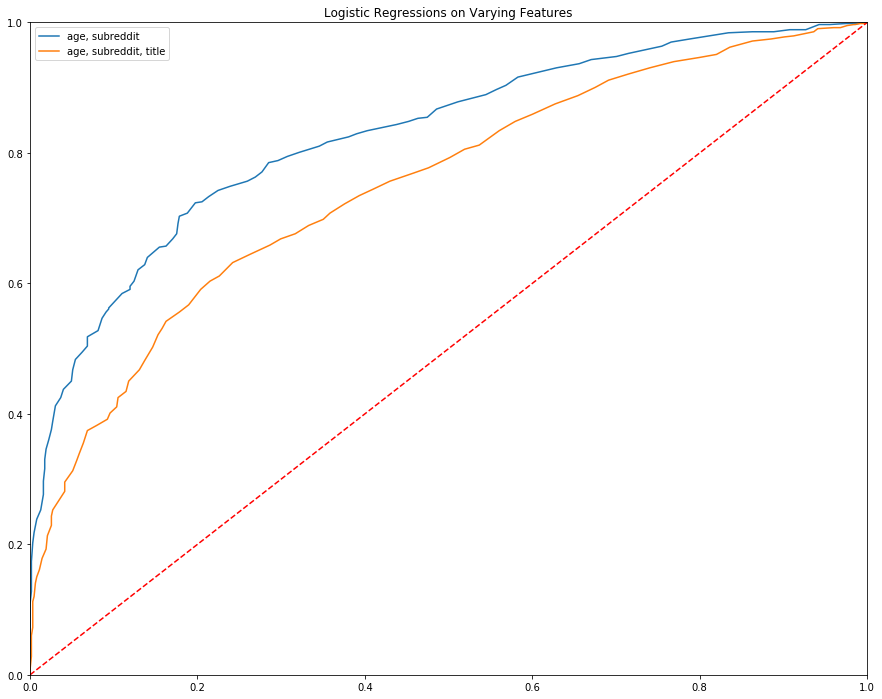

In [36]:
another_roc_plotter(models_to_plot, y_test, 'Logistic Regressions on Varying Features')

Title seems to hurt our model!  My interpretation of this result is that many different subreddits with many different topics contribute hot posts to our data set.  If titles convey topic information, and topics are very different across subreddits, we should expect to see titles vary across subreddits.

This leads me to wonder: will NLP on title data be more fruitful on a per-subreddit basis?  We'll have to do a lot of work to explore this option.  We'll need to choose our subreddits, scrape data from them, then rerun our analysis on that data.

#### Thought experiment: What is the baseline accuracy for this model?

## YOUR CODE HERE
50%

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

First, we'll run an untuned Random Forest Classifier and see what kind of performance and computation time we're looking at.

In [38]:
%%time
rf = RandomForestClassifier()
rf.fit(X_train_full, y_train)
print(rf.score(X_train_full, y_train), rf.score(X_test_full, y_test))

0.9788415763025654 0.6653449643140364
CPU times: user 1.83 s, sys: 400 ms, total: 2.23 s
Wall time: 2.23 s


This seems pretty overfit.  Let's cross-validated and gridsearch over some parameters.

In [39]:
gs_rf = GridSearchCV(RandomForestClassifier(),
                    {"n_estimators": [10,11,12],
                    "max_depth":[None, 2,3],
                    'warm_start':[True, False]},verbose=1)
gs_rf.fit(X_train_full, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   51.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 11, 12], 'max_depth': [None, 2, 3], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [43]:
gs_rf.best_score_

0.6836815657233536

Since the title-less features had a better ROC curve, let's see if those features do better in a random forest as well:

In [41]:
as_rf= GridSearchCV(RandomForestClassifier(),
                    {"n_estimators": [10,11,12],
                    "max_depth":[None, 2,3],
                    'warm_start':[True, False]},verbose=1)
as_rf.fit(X_train_as, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   12.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 11, 12], 'max_depth': [None, 2, 3], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [42]:
as_rf.best_score_

0.709336154456493

An improvement!  More evidence that titles are less important than age and subreddit.  Let's compare the RoC curves here.

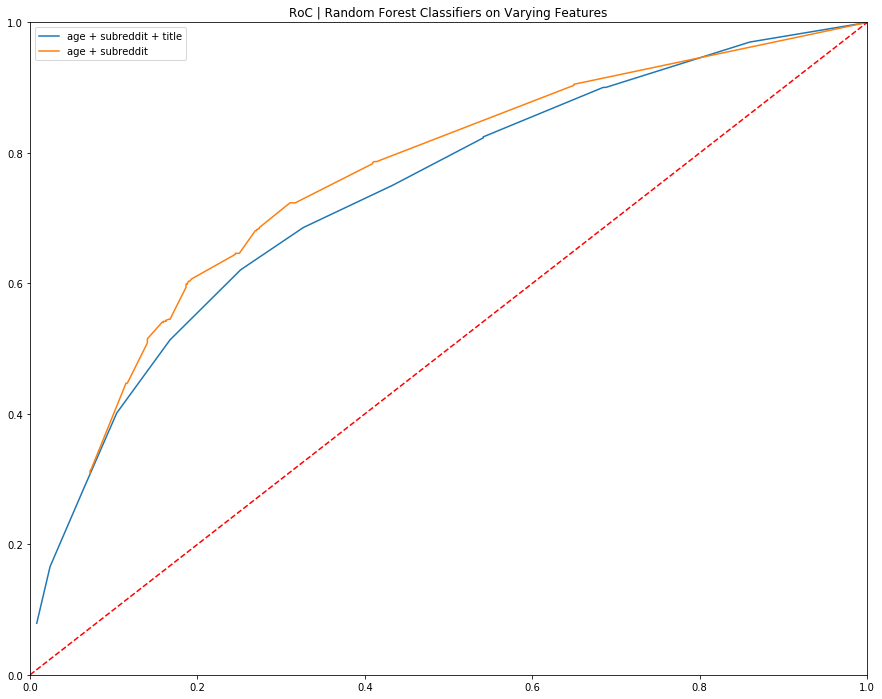

In [44]:
models = {'age + subreddit + title':gs_rf.predict_proba(X_test_full),
         'age + subreddit':as_rf.predict_proba(X_test_as)}
another_roc_plotter(models, y_test, "RoC | Random Forest Classifiers on Varying Features")

Pretty close, actually.

## Plot Post Timing

I thought of a plot that might be interesting, which would answer the following question: What time do people make posts on reddit, throughout the week?

To build this plot, we'll need to do some calculations on the 'created_utc' (for simplicity's sake due to time zone nonsense) to reconstruct the post's time-of-day and day-of-week information.

In [176]:
times = cumulative_df['created_utc'].astype('datetime64[s]')

times = pd.DatetimeIndex(times).tz_localize('UTC').tz_convert('America/Los_Angeles')

hours = (times.strftime('%H')).astype('int')

minutes = times.strftime('%M').astype('int')

seconds = times.strftime('%S').astype('int')

weekdays = pd.DatetimeIndex(np.datetime_as_string(times)).weekday_name

In [178]:
total_seconds = seconds + 60*minutes + (60**2)*hours

In [182]:
time_df = pd.DataFrame()
time_df['weekdays'] = weekdays
time_df['time'] = total_seconds

In [183]:
weekday_encoding = dict(Monday=0, Tuesday = 1, Wednesday = 2, Thursday = 3, Friday = 4, Saturday = 5, Sunday = 6)

In [186]:
time_df['weekdays_encoding'] = time_df['weekdays'].map(weekday_encoding)

In [189]:
time_df['target'] = y.sort_index().values

In [191]:
# Double checking that our time values makes sense.  There are 86400 seconds in a day.
time_df['time'].describe()

count     5042.000000
mean     30509.516462
std      18889.061242
min         85.000000
25%      18179.750000
50%      26146.500000
75%      37443.250000
max      86386.000000
Name: time, dtype: float64

Looks good.

In [209]:
time_df['funny'] = time_df['target'].map({0:'Low',1:'High'})

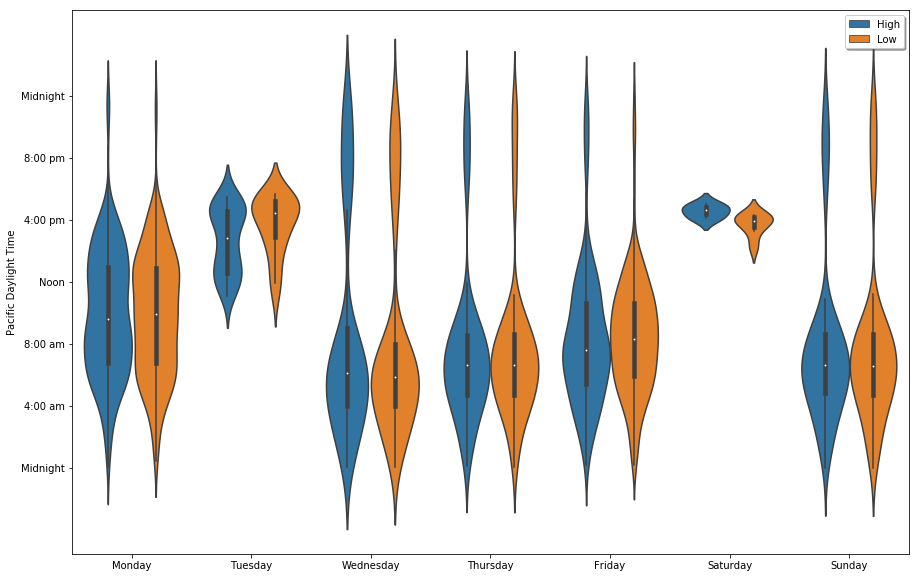

In [211]:
# Here's the tricky part.  We have to change the x labels, the ytick locations, and the ytick labels.
# I'm pretty happy with how this plot turned out.  One note--the shapes of the violins go outside
# the boundaries of the data due to kernel estimation nonsense.
plt.close()
plt.figure(figsize = (15,10))
ax = plt.gca()
g = sns.violinplot(ax = ax, data=time_df,x='weekdays_encoding',y='time', hue = 'funny', hue_order = ['High', 'Low'])
g.set(xticklabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#g.set_ylim(bottom = 0, top=86400)
plt.legend(loc = 1,fancybox=True,shadow = True,)
ax.set_xlabel("")
ax.set_ylabel("Pacific Daylight Time")
ax.set_yticks(np.linspace(0,86400, 7))
ax.set_yticklabels(["Midnight", "4:00 am", "8:00 am", "Noon", "4:00 pm", "8:00 pm", "Midnight"])
plt.show()

# Per-subreddit NLP success metrics

We'll being our per-subreddit analysis.  The new scraping logic is located in the companion notebook to this one.

In [348]:
cumulative_df.sort_values(by='num_comments', ascending=False).head(int(np.ceil(cumulative_df.shape[0]*(.1)))).groupby('subreddit').size().sort_values(ascending=False).head(10)

subreddit
news                 14
AskReddit            14
worldnews            13
pics                 12
funny                12
videos               11
gaming               11
gifs                 11
mildlyinteresting    10
MemeEconomy           9
dtype: int64

In [351]:
top_subreddits = list(cumulative_df.sort_values(by='num_comments', ascending=False).head(int(np.ceil(cumulative_df.shape[0]*(.1)))).groupby('subreddit').size().sort_values(ascending=False).head(10).index)

In [352]:
top_subreddits

['news',
 'AskReddit',
 'worldnews',
 'pics',
 'funny',
 'videos',
 'gaming',
 'gifs',
 'mildlyinteresting',
 'MemeEconomy']

## AskReddit analysis

This will be a test case for whether per-subreddit title analysis is worth doing.

In [18]:
# We'll load our cumulative csv for this subreddit, then drop duplicates (keeping the most recent).

askreddit_df = pd.read_csv("AskReddit-cumulative.csv")
print(askreddit_df.shape)
askreddit_df = askreddit_df.sort_values(by='num_comments', ascending=False)

askreddit_df = askreddit_df.drop_duplicates(subset='id')
print(askreddit_df.shape)

(4055, 79)
(2912, 79)


In [20]:
# We'll break down the posting times in order to do some feature engineering.

times = askreddit_df['created_utc'].astype('datetime64[s]')

times = pd.DatetimeIndex(times).tz_localize('UTC').tz_convert('America/Los_Angeles')

hours = (times.strftime('%H')).astype('int')

minutes = times.strftime('%M').astype('int')

seconds = times.strftime('%S').astype('int')

weekdays = pd.DatetimeIndex(np.datetime_as_string(times)).weekday_name

askreddit_df['hours'] = hours
askreddit_df['weekdays'] = weekdays

In [23]:
askreddit_df['target'] = askreddit_df['num_comments'].map(lambda x: 1 if x > askreddit_df['num_comments'].median() else 0)

In [24]:
# From the violin plots, we saw that posts happen more frequently at certain times than others.
# Let's group the day into four 6-hour periods
midnight = [21, 22, 23, 0 ,1, 2]
morning = [3,4,5,6,7,8]
noon = [9,10,11,12,13,14]
evening = [15, 16, 17, 18, 19, 20]


askreddit_df['is_midnight'] = askreddit_df['hours'].map(lambda x: 1 if x in midnight else 0)
askreddit_df['is_morning'] = askreddit_df['hours'].map(lambda x: 1 if x in morning else 0)
askreddit_df['is_noon'] = askreddit_df['hours'].map(lambda x: 1 if x in noon else 0)
askreddit_df['is_evening'] = askreddit_df['hours'].map(lambda x: 1 if x in evening else 0)

In [26]:
features = ['is_midnight', 'is_morning', 'is_noon', 'is_evening', 'weekdays', 'title']
X = askreddit_df[features]
y = askreddit_df['target']

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [8]:
# To do our NLP, we'll need to decide on a tokenizer in order to build our word vectors.
# This implements a custom tokenizer (there are a few easier ways to do this that I learned later, 
# but I'm preserving this because it involved defining a class, which I haven't had much occasion
# to do thus far.)


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = nltk.WordNetLemmatizer()
    def __call__(self, doc):
        sentences = nltk.sent_tokenize(doc)
        
        return [nltk.WordNetLemmatizer().lemmatize(w) for w in tokenizer.tokenize(doc)]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jameshampton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# This is a bread-and-butter fairly simple, fairly clumsy tokenizer based on alphanum chars.
tokenizer = nltk.RegexpTokenizer(r"([\w']+)")
tokenizer.tokenize("I'm afraid I can't let you do that, Dave")

["I'm", 'afraid', 'I', "can't", 'let', 'you', 'do', 'that', 'Dave']

In [34]:
# Process our dataframe:
# Vectorize the titles, then put them into a dataframe
tf = TfidfVectorizer(stop_words = 'english',ngram_range=(1,3),tokenizer=LemmaTokenizer())
X_train_counts = pd.DataFrame(tf.fit_transform(X_train['title']).todense(), index = X_train.index, columns = tf.get_feature_names())
X_test_counts = pd.DataFrame(tf.transform(X_test['title']).todense(), index=X_test.index, columns = tf.get_feature_names())

# Merge title-vector with our feature dataframe
X_train_full = pd.concat([X_train.drop('title', axis = 1), X_train_counts], axis=1)
X_test_full = pd.concat([X_test.drop('title', axis=1), X_test_counts], axis=1)

# Dummy out weekdays
X_train_full = pd.get_dummies(X_train_full, columns = ['weekdays'])
X_test_full = pd.get_dummies(X_test_full, columns = ['weekdays'])

# Equalize our levels
X_train_full, X_test_full = leveller(X_train_full, X_test_full)

In [560]:
params = {
    'C':np.logspace(-5,2,30),
}
gs_log = GridSearchCV(LogisticRegression(), params)
gs_log.fit(X_train_counts,y_train)
gs_log.best_params_, gs_log.score(X_test_counts, y_test)

({'C': 0.04175318936560404}, 0.5992217898832685)

In [35]:
# Tune a logistic model.  We get cross-validation for free using gridsearch.
params = {
    'C':np.logspace(-5,2,30),
}
gs_log = GridSearchCV(LogisticRegression(), params)
gs_log.fit(X_train_full,y_train)
gs_log.best_params_, gs_log.score(X_test_full, y_test)

({'C': 18.873918221350994}, 0.6318681318681318)

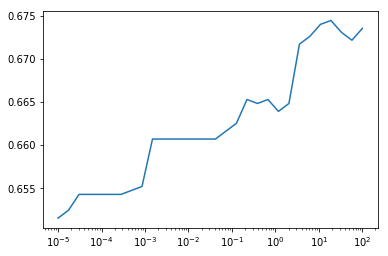

In [36]:
# Visualize how our accuracy varies over our parameter space.
plt.semilogx(np.logspace(-5,2,30),gs_log.cv_results_['mean_test_score'])

In [44]:
# What was our best accuracy?
gs_log.best_score_

0.6744505494505495

In [42]:
# Let's look at the best coefficients from the logistic model
pd.DataFrame(gs_log.best_estimator_.coef_, columns=X_test_full.columns,index=['coef']).T.sort_values(by='coef', ascending=False)

,coef
food,4.058035
weekdays_Thursday,3.935590
problem,3.915139
sex,3.663306
animal,3.508667
s like,3.507255
nsfw,3.475712
answer question,3.426319
person change,3.308716
truly,3.277800


Not a ton of correlation in the top title features.  We should collect posts over a longer timespan in order to reduce variance.

We left unexplored interactions among various time features: time-of-day, day-of-week, and age.  Further investigation of these interactions should be explored in future analysis.

# Random Forest Classifier

In [39]:
params = {
    'alpha':np.logspace(-5, 2, 10)
}
gs_mnb = GridSearchCV(MultinomialNB(), params)
gs_mnb.fit(X_train_full, y_train)
gs_mnb.score(X_test_full, y_test)

0.6346153846153846

In [40]:
params = {'max_features':np.linspace(0.1, 1.0, 10)
}

gs_rfc = GridSearchCV(RandomForestClassifier(),params)
gs_rfc.fit(X_train_full, y_train)
gs_rfc.score(X_test_full, y_test)

0.6098901098901099

These aren't very good models.  Multinomial NB and Logistic are roughly tied.  Since Logistic is more easily interpretable, we'll present the results from the logistic model.

In [41]:
# Let's look at the most important features from the rfc model.
pd.DataFrame(gs_rfc.best_estimator_.feature_importances_, index = X_test_full.columns).sort_values(by=0, ascending=False)

,0
is_noon,0.074993
is_midnight,0.027023
is_morning,0.019752
thing,0.010188
people,0.010108
is_evening,0.009025
weekdays_Thursday,0.008848
reddit,0.008785
ve,0.007508
did,0.006101


# Subreddit workflow

We'll generalize our AskReddit workflow to analyze the rest of the top subreddits.  Since Logistic models have been the best thus far, we'll stick with logistic models on the rest of the top subreddits.

I had a bit of inspiration here (although it didn't end up helping that much) after doing the violin plot to include some additional engineered time features--morning, noon, evening, midnight, as well as to include a day-of-week feature.

In [253]:
def get_train_test_features(subreddit, percentile):
    # Loard csv, drop duplicates
    subreddit_df = pd.read_csv(f"{subreddit}-cumulative.csv")
    subreddit_df = subreddit_df.sort_values(by='num_comments', ascending=False)
    subreddit_df = subreddit_df.drop_duplicates(subset='id')
    
    
    # Engineer time features - post age, day-of-week and time-of-day
    subreddit_df['age'] = subreddit_df['time_fetched'].astype('datetime64[s]') - subreddit_df['created_utc'].astype('datetime64[s]')

    subreddit_df['age_s'] = subreddit_df['age'].astype('timedelta64[s]')
    subreddit_df['age_mins'] = subreddit_df['age'].astype('timedelta64[m]')
    subreddit_df['age_hrs'] = subreddit_df['age'].astype('timedelta64[h]')

    
    times = subreddit_df['created_utc'].astype('datetime64[s]')

    times = pd.DatetimeIndex(times).tz_localize('UTC').tz_convert('America/Los_Angeles')

    hours = (times.strftime('%H')).astype('int')
    hours = (times.strftime('%H')).astype('int')
    weekdays = pd.DatetimeIndex(np.datetime_as_string(times)).weekday_name
    
    midnight = [21, 22, 23, 0 ,1, 2]
    morning = [3,4,5,6,7,8]
    noon = [9,10,11,12,13,14]
    evening = [15, 16, 17, 18, 19, 20]

    subreddit_df['hours'] = hours
    subreddit_df['weekdays'] = weekdays

    subreddit_df['is_midnight'] = subreddit_df['hours'].map(lambda x: 1 if x in midnight else 0)
    subreddit_df['is_morning'] = subreddit_df['hours'].map(lambda x: 1 if x in morning else 0)
    subreddit_df['is_noon'] = subreddit_df['hours'].map(lambda x: 1 if x in noon else 0)
    subreddit_df['is_evening'] = subreddit_df['hours'].map(lambda x: 1 if x in evening else 0)
    
    subreddit_df['target'] = subreddit_df['num_comments'].map(lambda x: 1 if x > subreddit_df['num_comments'].quantile(percentile) else 0)
    
    
    # Collect our features
    features = ['age_hrs', 'is_midnight', 'is_morning', 'is_noon', 'is_evening','weekdays', 'title']
    X = subreddit_df[features]
    y = subreddit_df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    
    # Vectorize title column, then add it back to the original dataframe.
    tf = TfidfVectorizer(stop_words = 'english',ngram_range=(1,3),tokenizer=LemmaTokenizer())
    X_train_counts = pd.DataFrame(tf.fit_transform(X_train['title']).todense(), index = X_train.index, columns = tf.get_feature_names())
    X_test_counts = pd.DataFrame(tf.transform(X_test['title']).todense(), index=X_test.index, columns = tf.get_feature_names())

    X_train_full = pd.concat([X_train.drop('title', axis = 1), X_train_counts], axis=1)
    X_test_full = pd.concat([X_test.drop('title', axis=1), X_test_counts], axis=1)

    X_train_full = pd.get_dummies(X_train_full, columns = ['weekdays'])
    X_test_full = pd.get_dummies(X_test_full, columns = ['weekdays'])

    X_train_full, X_test_full = leveller(X_train_full, X_test_full)
    
    return X_train_full, X_test_full, y_train, y_test

In [326]:
def get_top_log_coefs(X_train, X_test, y_train, y_test):
    params = {'C': np.logspace(-6, 2, 10)}
    gs_log = GridSearchCV(LogisticRegression(), params)
    gs_log.fit(X_train, y_train)
    
    # Make coefficient dataframe to return
    model = gs_log.best_estimator_
    coefs = model.coef_
    df = pd.DataFrame(coefs, index = ['coefs'], columns = X_train.columns)
    preds = [x[1] for x in model.predict_proba(X_test)]
    return df, gs_log.score(X_test, y_test), roc_auc_score(y_test, preds), gs_log.predict(X_test)
    

# Revisiting the General Analysis

We've engineered a few more features (related to time), and we've streamlined our workflow for the per-subreddit analysis.  Let's revisit the general analysis and see what we get.

In [243]:
def get_train_test_features_gen(percentile):
    # Loard csv, drop duplicates
    subreddit_df = pd.read_csv("reddit-cumulative.csv")
    subreddit_df = subreddit_df.sort_values(by='num_comments', ascending=False)
    subreddit_df = subreddit_df.drop_duplicates(subset='id')
    
    
    # Engineer time features - post age, day-of-week and time-of-day
    subreddit_df['age'] = subreddit_df['time_fetched'].astype('datetime64[s]') - subreddit_df['created_utc'].astype('datetime64[s]')

    subreddit_df['age_hrs'] = subreddit_df['age'].astype('timedelta64[h]')

    
    times = subreddit_df['created_utc'].astype('datetime64[s]')

    times = pd.DatetimeIndex(times).tz_localize('UTC').tz_convert('America/Los_Angeles')

    hours = (times.strftime('%H')).astype('int')
    hours = (times.strftime('%H')).astype('int')
    weekdays = pd.DatetimeIndex(np.datetime_as_string(times)).weekday_name
    
    midnight = [21, 22, 23, 0 ,1, 2]
    morning = [3,4,5,6,7,8]
    noon = [9,10,11,12,13,14]
    evening = [15, 16, 17, 18, 19, 20]

    subreddit_df['hours'] = hours
    subreddit_df['weekdays'] = weekdays

    subreddit_df['is_midnight'] = subreddit_df['hours'].map(lambda x: 1 if x in midnight else 0)
    subreddit_df['is_morning'] = subreddit_df['hours'].map(lambda x: 1 if x in morning else 0)
    subreddit_df['is_noon'] = subreddit_df['hours'].map(lambda x: 1 if x in noon else 0)
    subreddit_df['is_evening'] = subreddit_df['hours'].map(lambda x: 1 if x in evening else 0)
    
    subreddit_df['target'] = subreddit_df['num_comments'].map(lambda x: 1 if x > subreddit_df['num_comments'].quantile(percentile) else 0)
    
    
    # Collect our features
    features = ['age_hrs', 'is_midnight', 'is_morning', 'is_noon', 'is_evening','weekdays','subreddit', 'title']
    X = subreddit_df[features]
    y = subreddit_df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    
    X_train = pd.get_dummies(X_train, columns = ['weekdays', 'subreddit'])
    X_test = pd.get_dummies(X_test, columns = ['weekdays', 'subreddit'])
    # Vectorize title column, then add it back to the original dataframe.
    tf = TfidfVectorizer(stop_words = 'english',ngram_range=(1,3),tokenizer=LemmaTokenizer())
    X_train_counts = pd.DataFrame(tf.fit_transform(X_train['title']).todense(), index = X_train.index, columns = tf.get_feature_names())
    X_test_counts = pd.DataFrame(tf.transform(X_test['title']).todense(), index=X_test.index, columns = tf.get_feature_names())

    X_train_full = pd.concat([X_train.drop('title', axis = 1), X_train_counts], axis=1)
    X_test_full = pd.concat([X_test.drop('title', axis=1), X_test_counts], axis=1)
    
    print(type(X_train_full), X_train_full.shape)
    print(type(X_test_full), X_test_full.shape)
    
    

    X_train_full, X_test_full = leveller(X_train_full, X_test_full)
    
    return X_train_full, X_test_full, y_train, y_test

In [327]:
# Load up our variables
x1, x2, y1, y2 = get_train_test_features_gen(0.5)

df,acc,roc, preds = get_top_log_coefs(x1, x2, y1, y2)

<class 'pandas.core.frame.DataFrame'> (3781, 40121)
<class 'pandas.core.frame.DataFrame'> (1261, 39651)


In [346]:
# Take a look at our accuracy
acc

0.7494052339413164

Text(0.5,33,'Predicted')

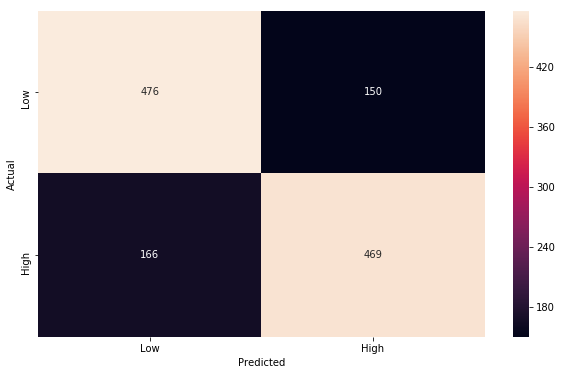

In [345]:
# Plot a confusion matrix
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y2,preds),annot=True, fmt='.0f')
ax = plt.gca()
ax.set_xticklabels(['Low', 'High'])
ax.set_yticklabels(['Low', 'High'])
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")

Let's take a look at our RoC score and accuracy

In [249]:
c

0.829378385998832

In [250]:
b

0.7636796193497224

Pretty good!  What are our coefficients?

In [319]:
coefs_df = a.T

coefs_df['coefs_sq'] = coefs_df['coefs']**2

coefs_df.sort_values(by = 'coefs_sq', ascending=False)

,coefs,coefs_sq
subreddit_funny,5.039139,2.539293e+01
subreddit_pics,4.856225,2.358292e+01
subreddit_aww,4.404263,1.939753e+01
subreddit_FortNiteBR,4.371606,1.911094e+01
subreddit_gifs,4.346882,1.889539e+01
subreddit_worldnews,4.336696,1.880693e+01
subreddit_MMA,4.193082,1.758193e+01
subreddit_gaming,4.154512,1.725997e+01
subreddit_MemeEconomy,4.097548,1.678990e+01
subreddit_movies,4.080697,1.665209e+01


In [255]:
# These were the top subreddits from analyzing the general reddit data.
top_subreddits = ['news',
 'AskReddit',
 'worldnews',
 'pics',
 'funny',
 'videos',
 'gaming',
 'gifs',
 'mildlyinteresting',
 'MemeEconomy']

In [99]:
# Build out our logistic models for each subreddit.  Save their coefficients, feature names, and RoC score for analysis.
top_coefs = []
bottom_coefs = []
scores = []
for subreddit in top_subreddits:
    x1, x2, y1, y2 = get_train_test_features(subreddit, 0.5)
    coefs, acc, roc = get_top_log_coefs(x1, x2,y1, y2)
    sort = coefs.T.sort_values(by='coefs', ascending=False)
    top_coefs.append((subreddit,sort.head(25)))
    bottom_coefs.append((subreddit, sort.tail(25)))
    scores.append((subreddit, acc, roc))

In [256]:
# Let's take a look at our scores
scores

[('news', 0.6666666666666666, 0.7113740959894805),
 ('AskReddit', 0.6978021978021978, 0.760150052457977),
 ('worldnews', 0.6396396396396397, 0.6995522172468583),
 ('pics', 0.6468699839486356, 0.6897157508229932),
 ('funny', 0.681260945709282, 0.7385718498857186),
 ('videos', 0.6857142857142857, 0.7422666666666667),
 ('gaming', 0.6452905811623246, 0.7059182624341345),
 ('gifs', 0.46511627906976744, 0.5294171498321636),
 ('mildlyinteresting', 0.6015625, 0.6360756537982566),
 ('MemeEconomy', 0.7850162866449512, 0.8776482600187185)]

In [127]:
# Our list of subreddits
[x[0] for x in top_coefs]

['news',
 'AskReddit',
 'worldnews',
 'pics',
 'funny',
 'videos',
 'gaming',
 'gifs',
 'mildlyinteresting',
 'MemeEconomy']

These next two cells I used to collect some interesting positve and negative predictors for the subreddits.

In [154]:
top_coefs[9][1]

,coefs
weekdays_Sunday,1.590249
weekdays_Monday,1.233647
weekdays_Tuesday,0.600130
versatile,0.442704
high,0.275496
potential,0.211423
original,0.184165
short,0.172233
hentai,0.166920
term,0.163317


In [155]:
bottom_coefs[9][1]

,coefs
new,-0.115534
potential buy,-0.119461
possible new format,-0.119984
political,-0.122001
new format invest,-0.122829
format return,-0.123696
love,-0.124025
like,-0.126516
profitable,-0.132565
possible template,-0.134295


#### Subreddit analysis Sans Title

Since title information introduced more noise than signal to our general reddit analysis, let's see how our RoC scores change if we omit title information.  We'll have to design a slightly different workflow here.

In [96]:
def get_train_test_features_sans_title(subreddit, percentile):
    # Loard csv, drop duplicates
    subreddit_df = pd.read_csv(f"{subreddit}-cumulative.csv")
    subreddit_df = subreddit_df.sort_values(by='num_comments', ascending=False)
    subreddit_df = subreddit_df.drop_duplicates(subset='id')
    
    
    # Engineer time features - post age, day-of-week and time-of-day
    subreddit_df['age'] = subreddit_df['time_fetched'].astype('datetime64[s]') - subreddit_df['created_utc'].astype('datetime64[s]')

    subreddit_df['age_s'] = subreddit_df['age'].astype('timedelta64[s]')
    subreddit_df['age_mins'] = subreddit_df['age'].astype('timedelta64[m]')
    subreddit_df['age_hrs'] = subreddit_df['age'].astype('timedelta64[h]')

    
    times = subreddit_df['created_utc'].astype('datetime64[s]')

    times = pd.DatetimeIndex(times).tz_localize('UTC').tz_convert('America/Los_Angeles')

    hours = (times.strftime('%H')).astype('int')
    hours = (times.strftime('%H')).astype('int')
    weekdays = pd.DatetimeIndex(np.datetime_as_string(times)).weekday_name
    
    midnight = [21, 22, 23, 0 ,1, 2]
    morning = [3,4,5,6,7,8]
    noon = [9,10,11,12,13,14]
    evening = [15, 16, 17, 18, 19, 20]

    subreddit_df['hours'] = hours
    subreddit_df['weekdays'] = weekdays

    subreddit_df['is_midnight'] = subreddit_df['hours'].map(lambda x: 1 if x in midnight else 0)
    subreddit_df['is_morning'] = subreddit_df['hours'].map(lambda x: 1 if x in morning else 0)
    subreddit_df['is_noon'] = subreddit_df['hours'].map(lambda x: 1 if x in noon else 0)
    subreddit_df['is_evening'] = subreddit_df['hours'].map(lambda x: 1 if x in evening else 0)
    
    subreddit_df['target'] = subreddit_df['num_comments'].map(lambda x: 1 if x > subreddit_df['num_comments'].quantile(percentile) else 0)
    
    
    # Collect our features
    features = ['age_hrs', 'is_midnight', 'is_morning', 'is_noon', 'is_evening','weekdays']
    X = subreddit_df[features]
    y = subreddit_df['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)

    X_train = pd.get_dummies(X_train, columns = ['weekdays'])
    X_test = pd.get_dummies(X_test, columns = ['weekdays'])

    X_train, X_test = leveller(X_train, X_test)
    
    return X_train, X_test, y_train, y_test

In [98]:
# Get our scores
top_coefs_sans_title = []
bottom_coefs_sans_title = []
scores_sans_title = []
for subreddit in top_subreddits:
    x1, x2, y1, y2 = get_train_test_features_sans_title(subreddit, 0.5)
    coefs, acc, roc = get_top_log_coefs(x1, x2,y1, y2)
    sort = coefs.T.sort_values(by='coefs', ascending=False)
    top_coefs_sans_title.append((subreddit,sort.head(25)))
    bottom_coefs_sans_title.append((subreddit, sort.tail(25)))
    scores_sans_title.append((subreddit, acc, roc))

In [105]:
# MAke some dataframes so the data will be readable
titles = pd.DataFrame(scores, columns = ['subreddit', 'accuracy', 'AuC-RoC score'])
no_titles = pd.DataFrame(scores_sans_title, columns = ['subreddit', 'accuracy', 'AuC-RoC score'])

In [ ]:
titles.columns = ['subreddit', 't_accuracy', 't_AuC-RoC score']

In [258]:
no_titles

,subreddit,accuracy,AuC-RoC score
0,news,0.653846,0.691030
1,AskReddit,0.696429,0.750789
2,worldnews,0.582583,0.626079
3,pics,0.605136,0.616449
4,funny,0.679510,0.746601
5,videos,0.691429,0.721066
6,gaming,0.627255,0.670900
7,gifs,0.534884,0.562421
8,mildlyinteresting,0.609375,0.568483
9,MemeEconomy,0.755700,0.835041


Looks like Accuracy and AuC-RoC scores are generally higher with title information.  

In [111]:
# These are the features for which adding title information improved the AuC-RoC score
titles['subreddit'][(titles['AuC-RoC score'] - no_titles['AuC-RoC score'])>0]

0                 news
1            AskReddit
2            worldnews
3                 pics
5               videos
6               gaming
8    mildlyinteresting
9          MemeEconomy
Name: subreddit, dtype: object

In [112]:
# These are the features for which adding title information worsened the AuC-RoC score
titles['subreddit'][(titles['AuC-RoC score'] - no_titles['AuC-RoC score'])<0]

4    funny
7     gifs
Name: subreddit, dtype: object

In [310]:
# Load our roc score information into a single dataframe to make visualization easier
data = pd.concat([titles,no_titles.drop('subreddit', axis=1)],join='inner', axis=1)
data['pos'] = ((data['t_AuC-RoC score'] - data['AuC-RoC score'])>0).astype(int)
data['diff'] = data['t_AuC-RoC score'] - data['AuC-RoC score']

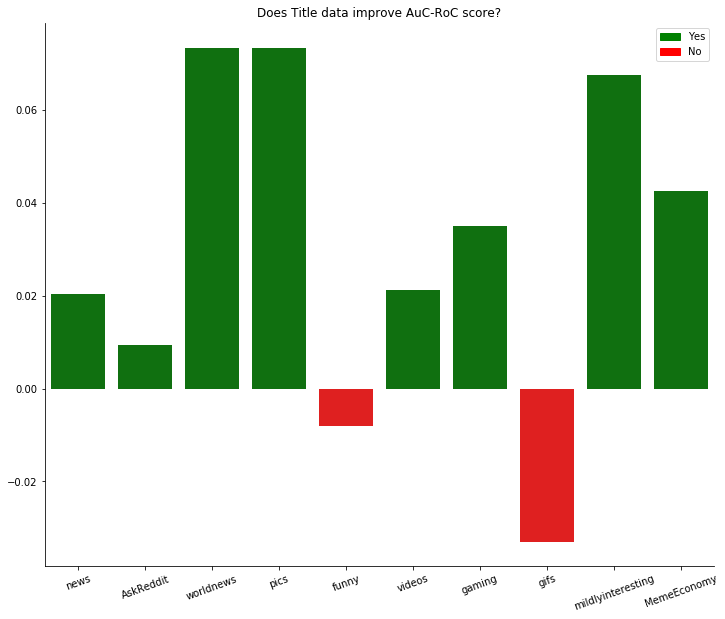

In [347]:
# Visualize which subreddits benefit from analyzing titles
import matplotlib.patches as mpatches



plt.figure(figsize = (12,10))
ax = plt.gca()
colors = ['green' if _y ==1 else 'red' for _y in data['pos']]

g = sns.barplot(data.index, data['t_AuC-RoC score'] - data['AuC-RoC score'],data=data, palette = colors)
ax.set_xticks(data.index)
ax.set_xticklabels(data['subreddit'])
for item in g.get_xticklabels():
    item.set_rotation(20)
sns.despine()
plt.title("Does Title data improve AuC-RoC score?")
red_patch = mpatches.Patch(color='red', label='No')
green_patch = mpatches.Patch(color = 'green', label = 'Yes')
plt.legend(handles=[green_patch,red_patch])
plt.show()

Intersting results here.  Intuitively it makes sense that image/video content would drive the number of comments in subreddits like *videos*, *gifs*, and *pics*, which suggests that the title doesn't tell the whole story.  Title information was damaging to the model for *funny* and *gifs*, but helpful for *videos* and *pics*.  We might conclude from this that *videos* and *pics* encourage a stronger connection between the content of a post and its title.  It also makes sense that title information would be less important in *funny*, since a title will be chosen for the purpose of being funny rather than descriptive *per se*.